In [1]:
import numpy as np
import pylab as plt

from bornagain.simulate import ThornAgain
from bornagain import SimpleDetector

In [2]:
# define a gold dimer (simple!)
a_gld = 4.079
dimer = np.array([[0,0,0], [a_gld,0,0]] )


In [3]:
# define a detector that spans interesting q-range
D = SimpleDetector(n_pixels=500, detdist=0.04, wavelen=0.8)
print D.Qmag.min(), D.Qmag.max() # 'inverse angstrom'

0.00490873780218 3.24760851074


In [4]:
T = ThornAgain(D.Q, dimer, np.ones(2)*79, group_size=64) # prep the simulator

Took 0.0143 sec to complete...


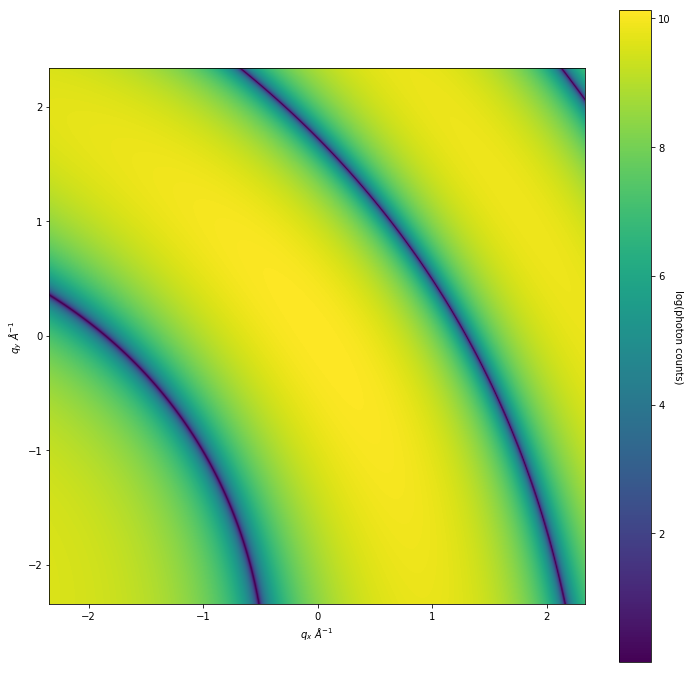

In [6]:
# lets look at a single exposure
amp = T.run(rand_rot=True)
_ = D.readout(amp)
D.display(figsize=(12,12))

In [20]:
%%capture  
# takes about 7 seconds on zim 
shots = [  D.readout(T.run(rand_rot=True)) \
    for _ in xrange( 1000)]  # makes amsplitudes for 1000 orientationssu

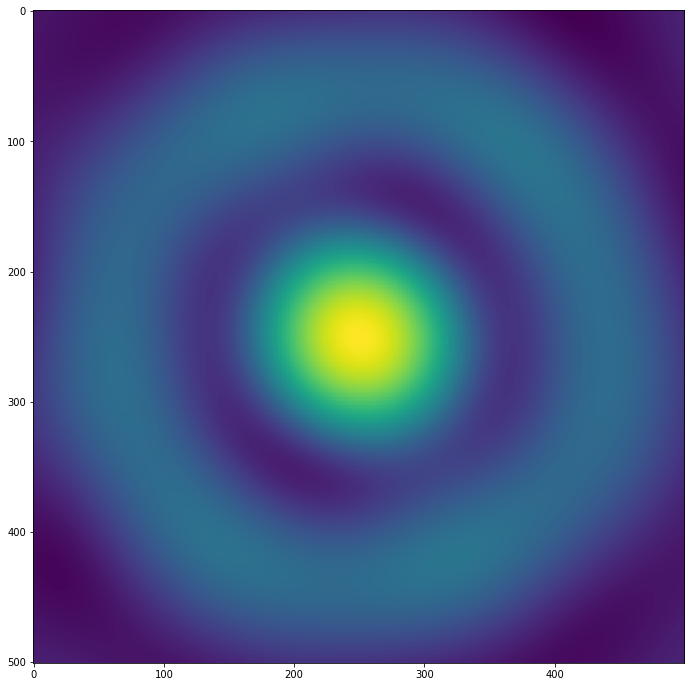

In [21]:
# lets look at the powder sum
plt.figure(figsize=(12,12))
plt.imshow( np.mean(shots,0), norm=plt.mpl.colors.LogNorm())
plt.show()

In [30]:
# now to do the correlations we can use the package loki
# https://github.com/dermen/loki.git
from loki.RingData import InterpSimple, DiffCorr

# first step is to interpolate the images to polar pixel coordinates
a,b = D.img_sh[1]/2., D.img_sh[0]/2. # center of detector image
qRmin, qRmax = 24, 240 # max, min pixel radii (with some cushion)
nphi = int(2*np.pi*qRmax) # how many points to sample azimuthally 

In [33]:
Interp = InterpSimple(a,b, qRmax=qRmax, qRmin=qRmin, nphi=nphi, raw_img_shape=D.img_sh)

In [34]:
%time polar_shots = [ Interp.nearest(s) for s in shots]

CPU times: user 1.7 s, sys: 489 ms, total: 2.19 s
Wall time: 2.19 s


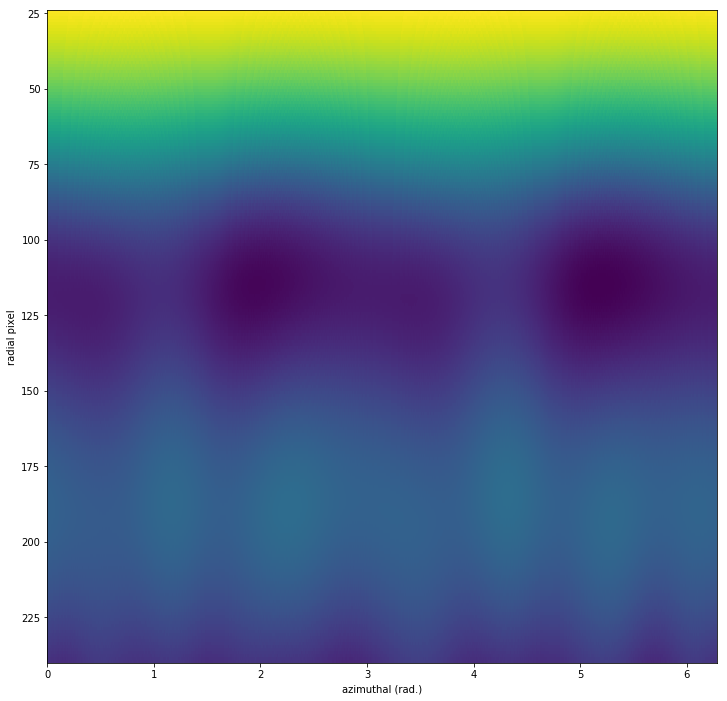

In [38]:
# lets look at the powder sum in polar
plt.figure(figsize=(12,12))
extent = (0,2*np.pi, qRmax, qRmin)
plt.imshow( np.mean(polar_shots,0), norm=plt.mpl.colors.LogNorm(), extent=extent, aspect='auto')
plt.xlabel('azimuthal (rad.)')
plt.ylabel('radial pixel')
plt.show()

In [39]:
# now we can do the auto correlations using DiffCorr
DC = DiffCorr(np.array( polar_shots), pre_dif=True)
%time cors = DC.autocorr() 

CPU times: user 1min 49s, sys: 842 ms, total: 1min 50s
Wall time: 1min 50s


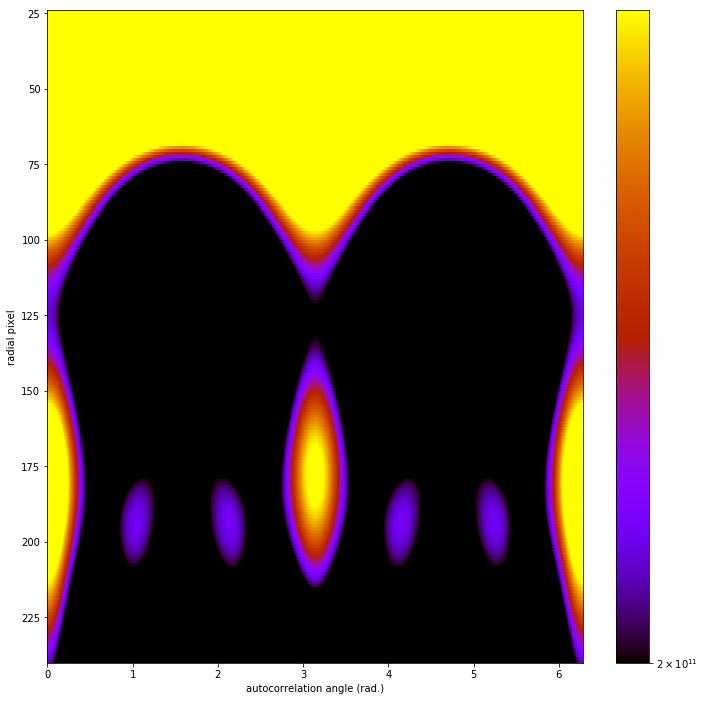

In [51]:
# didnt take too long..
# this will be the target function for the dimer solution correlations.. 
plt.figure(figsize=(12,12))
ave_cor = cors.mean(0)
extent = (0,2*np.pi, qRmax, qRmin)
plt.imshow( ave_cor, norm=plt.mpl.colors.SymLogNorm(10), vmin=2e11,
           vmax=2.5e11,extent=extent, aspect='auto', cmap='gnuplot')
plt.xlabel('autocorrelation angle (rad.)')
plt.ylabel('radial pixel')
plt.show()